In [1]:
import pickle
import numpy as np
import os
import tensorflow as tf
import time
import h5py
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
#Load indices and the itoword dictionary
word_dict = open("word_dict.pkl", "rb")
word_dict = pickle.load(word_dict)

In [3]:
print(len(word_dict))
print(word_dict[1])
print(word_dict[2])

1004
x_START_
x_END_


In [6]:
ROOT_DIR = os.getcwd()
print('ROOT:', ROOT_DIR)
EMBED_DIR = os.path.join(ROOT_DIR, 'attention_embed')
print('embeddings:', EMBED_DIR)
CAPTION_DIR = os.path.join(ROOT_DIR, 'attention_captions')
print('captions:', CAPTION_DIR)
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
print('images:', IMAGE_DIR)
MODEL_DIR = os.path.join(ROOT_DIR, 'attention_models')
print('models:', MODEL_DIR)

ROOT: C:\Users\ayhok\Desktop\EEE443 Project
embeddings: C:\Users\ayhok\Desktop\EEE443 Project\attention_embed
captions: C:\Users\ayhok\Desktop\EEE443 Project\attention_captions
images: C:\Users\ayhok\Desktop\EEE443 Project\images
models: C:\Users\ayhok\Desktop\EEE443 Project\attention_models


In [7]:
sampleList = os.listdir(EMBED_DIR)
print(len(sampleList))
print(sampleList[0:10])

validImageList = [(int(s.replace('.npy', ''))) for s in sampleList]
print(validImageList[0:10])

trial = np.load(os.path.join(EMBED_DIR, sampleList[0]))
print('Shape of one embedding:', trial.shape)

73651
['1.npy', '10.npy', '100.npy', '1000.npy', '10000.npy', '10001.npy', '10002.npy', '10003.npy', '10004.npy', '10006.npy']
[1, 10, 100, 1000, 10000, 10001, 10002, 10003, 10004, 10006]
Shape of one embedding: (1, 8, 8, 2048)


In [8]:
f = h5py.File(ROOT_DIR + '\\eee443_project_dataset_train.h5', 'r')
print(f.keys())
trainImid = f['train_imid'].value
print(trainImid)

trainCap = f['train_cap'].value
print(trainCap[0])

<KeysViewHDF5 ['train_cap', 'train_imid', 'train_ims', 'train_url', 'word_code']>
[53315 21549 53315 ... 37874  5087 28657]
[  1   4 142 510  10 667 415 277  58   2   0   0   0   0   0   0   0]


c:\users\ayhok\appdata\local\programs\python\python37\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [9]:
#extract captions for existing images
def retreive_capt_id(image_id ,imid_list, cap_list):
    capList = []
    idList = []
    caps = np.where(imid_list == image_id)[0]
    caps = cap_list[caps]
    for cap in caps:
        capList.append(cap)
        idList.append(image_id)
    return capList, idList

def retreive_capt_batch(image_id_list ,imid_list, cap_list):
    idList = []
    captionsList = []
    for image_id in image_id_list:
        caps, ids = retreive_capt_id(image_id,imid_list,cap_list)
        captionsList.extend(caps)
        idList.extend(ids)
    return np.asarray(captionsList), np.asarray(idList)


In [10]:
captionsList, captionIDList = retreive_capt_batch(validImageList,trainImid, trainCap)
print(captionsList.shape)
print(captionIDList.shape)

print(captionsList[0:15,:])
print(captionIDList[0:15])

if not os.path.exists(CAPTION_DIR):
    os.mkdir(CAPTION_DIR)
    np.save(os.path.join(CAPTION_DIR, 'captionsAttention.npy'), captionsList)
    np.save(os.path.join(CAPTION_DIR, 'captionsIDAttention.npy'), captionIDList)


(356052, 17)
(356052,)
[[  1   4 341  54 592  99 506  10 287   2   0   0   0   0   0   0   0]
 [  1   4 249 341  24   9   3   3 165 287   2   0   0   0   0   0   0]
 [  1   4 249  24   9   4 581   5  33   6  31 400   9  99 287   2   0]
 [  1   4 249  24   9   4 497   3   8   7 222  80   3   2   0   0   0]
 [  1   4  24  11   3   9  99 287   9  60   3   2   0   0   0   0   0]
 [  1  16  19   8   4  61 125 107  72  18  15   3   2   0   0   0   0]
 [  1   4  12   8   4   3  10 254   3  93   4 185   2   0   0   0   0]
 [  1   4  12   8   4  61 562  72  32  18   4 238   6 328   2   0   0]
 [  1   4  12   9   4   3  10   4  60 189  11 460  30  61   2   0   0]
 [  1   4  28 507 143   7 185   6   4  61 125   2   0   0   0   0   0]
 [  1   4 592 831  11   3   9   3 704  10   3 400  50   3 746 669   2]
 [  1   4  58   9   3 704  10 715   3   2   0   0   0   0   0   0   0]
 [  1 704  10   3   9   3   3   8   4 509 831   2   0   0   0   0   0]
 [  1   4  77   6   3 614  13   4 137   8   4 831   2 

In [11]:
#Load cached caption-id matched lists
captionList = np.load(os.path.join(CAPTION_DIR,'captionsAttention.npy'))
captionIDList = np.load(os.path.join(CAPTION_DIR,'captionsIDAttention.npy'))
print(captionList.shape, captionIDList.shape)

#split train and test
img_name_train, img_name_val, cap_train, cap_val = train_test_split(captionIDList, captionList,test_size=0.1, random_state=0)
print('Train ImIDs and Captions', img_name_train.shape, cap_train.shape)
print('Val ImIDs and Captions', img_name_val.shape, cap_val.shape)

(356052, 17) (356052,)
Train ImIDs and Captions (320446,) (320446, 17)
Val ImIDs and Captions (35606,) (35606, 17)


In [12]:
#Hyperparameters
BATCH_SIZE = 487
#for shuffling
BUFFER_SIZE = 1000
#using glove6b/200 
embedding_dim = 256
#unit num for attention
units = 512

vocab_size = len(word_dict)
batch_num = int(len(img_name_train)/BATCH_SIZE)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

def map_func(img_name, cap):
    #load feature
    embed_tensor = np.load(os.path.join(EMBED_DIR, str(img_name)+'.npy'))
    #reshape the 1x8x8x2048 tensor to 64x2048
    n,x,y,z = embed_tensor.shape
    embed_tensor = embed_tensor.reshape((x*y,z))
    return embed_tensor, cap

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
class SoftAttention(tf.keras.Model):
    def __init__(self, fcDim):
        super(SoftAttention, self).__init__()
        self.featLayer = tf.keras.layers.Dense(fcDim)
        self.hidLayer = tf.keras.layers.Dense(fcDim)
        self.sumLayer = tf.keras.layers.Dense(1)
    
    #explained in report
    def call(self, features, hidden):
        hidden_exp = tf.expand_dims(hidden, 1)

        sumLayers = self.featLayer(features) + self.hidLayer(hidden_exp)
        relevanceScore = tf.nn.tanh(sumLayers)
        
        attWeights = tf.nn.softmax(self.sumLayer(relevanceScore), axis=1)
        #ottend over features by estimating expectation
        contextVec = attWeights * features
        contextVec = tf.reduce_sum(contextVec, axis=1)

        return contextVec, attWeights

In [15]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.outLayer = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.outLayer(x)
        x = tf.nn.relu(x)
        return x

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.attention = SoftAttention(self.units)
        #use glove vectors as weights
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, recurrent_initializer='glorot_uniform', return_sequences=True, return_state=True)
        self.fcHid = tf.keras.layers.Dense(self.units)
        self.fcOut = tf.keras.layers.Dense(vocab_size)


    def call(self, x, features, hidden):
        contextVec, attWeights = self.attention(features, hidden)
        # extract embedding
        x = self.embedding(x)
        temp = tf.expand_dims(contextVec, 1)
        #concat the enbedding with context vector
        x = tf.concat([temp, x], axis=-1)        
        # pass the concatenated vector gru
        output, state = self.gru(x)
        x = self.fcHid(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fcOut(x)
        return x, state, attWeights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [17]:
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)

In [22]:
lossFcn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def customLoss(real, pred):
    lossVal = lossFcn(real, pred)
    mask = tf.cast(tf.math.logical_not(tf.math.equal(real, 0)),  dtype=lossVal.dtype)
    lossVal *= mask
    return tf.reduce_mean(lossVal)

In [23]:
lossList = []
optim = tf.keras.optimizers.Adam()

@tf.function
def trainingStep(img_embed, caption):
    loss = 0
    #reset hidden state
    hidden = decoder.reset_state(batch_size=caption.shape[0])
    
    #In our data, this corresponds to x_START_
    START_INDEX = 1
    dec_input = tf.expand_dims([START_INDEX] * caption.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #pass through encoder
        features = encoder(img_embed)
        #train rnn with teacher forcing (recursive)
        for i in range(1, caption.shape[1]):
          # pass through decoder 
            pred, hidden, _ = decoder(dec_input, features, hidden)
            loss += customLoss(caption[:, i], pred)
            dec_input = tf.expand_dims(caption[:, i], 1)

    total_loss = (loss / int(caption.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optim.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [26]:
EPOCHS = 40

for epoch in range(EPOCHS):
    start_time = time.time()
    total_loss = 0

    for (batch, (embed_tensor, caption)) in enumerate(dataset):
        running_loss, total_loss_t = trainingStep(embed_tensor, caption)
        total_loss += total_loss_t

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.8f}'.format( epoch + 1, batch, running_loss.numpy() / int(caption.shape[1])))
    lossList.append(total_loss / batch_num)
    dur = time.time() - start_time
    #report epoch err and time
    print ('Epoch {} CE Error {:.8f}'.format(epoch + 1, total_loss/batch_num))
    print ('Duration {} seconds\n'.format(dur))

Epoch 1 Batch 0 Loss 4.32373944
Epoch 1 Batch 100 Loss 2.28638054
Epoch 1 Batch 200 Loss 2.04437907
Epoch 1 Batch 300 Loss 1.92740766
Epoch 1 Batch 400 Loss 1.84720589
Epoch 1 Batch 500 Loss 1.83282875
Epoch 1 Batch 600 Loss 1.79976699
Epoch 1 CE Error 2.03928518
Duration 413.76742672920227 seconds

Epoch 2 Batch 0 Loss 1.79566922
Epoch 2 Batch 100 Loss 1.79961766
Epoch 2 Batch 200 Loss 1.76895287
Epoch 2 Batch 300 Loss 1.76032134
Epoch 2 Batch 400 Loss 1.70620324
Epoch 2 Batch 500 Loss 1.68046794
Epoch 2 Batch 600 Loss 1.69479572
Epoch 2 CE Error 1.72896922
Duration 424.1251871585846 seconds

Epoch 3 Batch 0 Loss 1.66258531
Epoch 3 Batch 100 Loss 1.71761143
Epoch 3 Batch 200 Loss 1.70036630
Epoch 3 Batch 300 Loss 1.67859975
Epoch 3 Batch 400 Loss 1.59270859
Epoch 3 Batch 500 Loss 1.61971059
Epoch 3 Batch 600 Loss 1.61551588
Epoch 3 CE Error 1.65001214
Duration 431.5504925251007 seconds

Epoch 4 Batch 0 Loss 1.64103093
Epoch 4 Batch 100 Loss 1.61223995
Epoch 4 Batch 200 Loss 1.59390752

In [27]:
def print_pred(imgID):
    print('-----------------------------\nSample ID', imgID)
    img = PIL.Image.open(os.path.join(IMAGE_DIR,str(imgID)))
    plt.imshow(img)
    plt.show()
    
    print('\nCaptions:')
    captions = retreive_capt_id(imgID, trainImid, trainCap)[0]
    captionsStr = []
    for caption in captions:
        capStr = ''
        cap = []
        for word in caption:
            if(word != 2 and word != 1 and word != 0):
                capStr += word_dict[word] + ' '
                cap.append(word_dict[word])
        print(capStr)
        captionsStr.append(cap)
                
    embed = np.load(os.path.join(EMBED_DIR, str(imgID)+'.npy'))
    pred = evaluate(embed)
    predLst = []
    capStr = '\nPrediction:'
    for word in pred:
        if(word != 2 and word != 1 and word != 0):
            capStr += word_dict[word] + ' '
            predLst.append(word_dict[word])
    
    print('\nBLEU Score', sentence_bleu(captionsStr,predLst))
    print(capStr)

In [32]:
def evaluate(embedding):
    hidden = decoder.reset_state(batch_size=1)
    embedding = tf.reshape(embedding, (embedding.shape[0], -1, embedding.shape[3]))
    #pass through encoder
    features = encoder(embedding)
    
    START_INDEX = 1
    END_INDEX = 2
    MAX_LEN = 17
    dec_input = tf.expand_dims([START_INDEX], 0)
    result = []

    # don't use teacher forcing this time
    for i in range(MAX_LEN):
        preds, hidden, _= decoder(dec_input, features, hidden)
        predictedWord = tf.argmax(preds,axis=1).numpy()
        result.append(predictedWord[0])
        if predictedWord == 2:
            return result
        dec_input = tf.expand_dims([predictedWord[0]], 0)

    return result

-----------------------------
Sample ID 82600


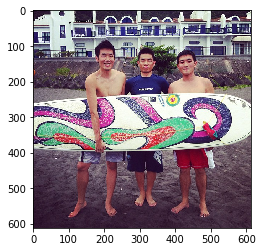


Captions:
three men holding a surfboard on the beach in the x_UNK_ 
three young men holding a large surf board are posing xFor the camera 
three young men standing together holding a surfboard 
three young men holding a surfboard on the beach 
three young men pose xFor the camera holding a decorated surf board 

BLEU Score 4.797597231912944e-78

Prediction:three young men playing a game of tennis 
-----------------------------
Sample ID 10514


c:\users\ayhok\appdata\local\programs\python\python37\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


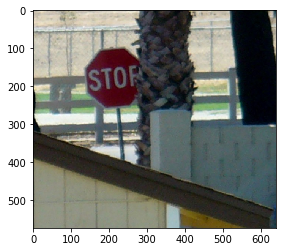


Captions:
a picture of an open air x_UNK_ that looks x_UNK_ 
a stop sign behind a wall and palm tree 
a stop sign is seen in front of a white fence 
a stop sign on the side of a clear road 
a stop x_UNK_ near the trunk of a palm tree 

BLEU Score 0.8891397050194614

Prediction:a stop sign on the side of a road 
-----------------------------
Sample ID 25561


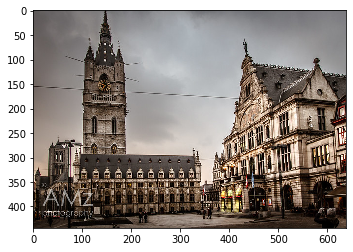


Captions:
a very tall clock tower x_UNK_ over a city 
this is a photo of a very old church and and x_UNK_ 
people in a x_UNK_ looking a x_UNK_ buildings 
an old time x_UNK_ looking x_UNK_ scene 
two old big buildings sitting next to each other 

BLEU Score 8.534204031625306e-155

Prediction:a clock is on a x_UNK_ x_UNK_ x_UNK_ 
-----------------------------
Sample ID 4628


c:\users\ayhok\appdata\local\programs\python\python37\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


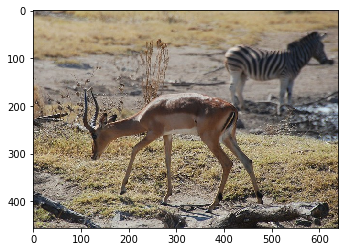


Captions:
a x_UNK_ standing near a zebra in the dirt 
a x_UNK_ and zebra graze on an open plain 
two animals in the middle of a dessert like area 
an x_UNK_ grazing on grass next to a zebra 
an x_UNK_ is walking with a zebra in the distance 

BLEU Score 4.685541510640215e-78

Prediction:a large elephant is standing in the dirt 
-----------------------------
Sample ID 39661


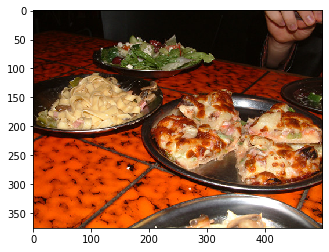


Captions:
x_UNK_ x_UNK_ with pizza sitting on top of a table 
a table with pizza and some other foods on it 
the half eaten meal x_UNK_ of pizza and pasta 
metal x_UNK_ of food sitting on a tile counter 
pizza pasta and salad on x_UNK_ metal plates sit on orange tiled counter 

BLEU Score 7.5314086239343e-155

Prediction:a x_UNK_ x_UNK_ pizza with x_UNK_ and x_UNK_ 
-----------------------------
Sample ID 66111


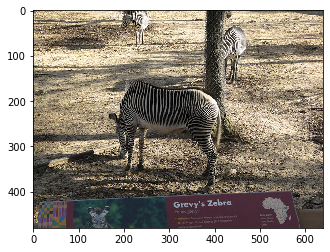


Captions:
a zebra that is in the dirt near a tree 
zebras in a pen at the zoo grazing and x_UNK_ around the enclosure 
zebras grazing at the zoo on a sunny day 
there are three zebras grazing xFor food in a zoo enclosure 
several zebras eat grass in a zoo x_UNK_ 

BLEU Score 4.38832006142665e-78

Prediction:a train is going down the tracks near a tree 
-----------------------------
Sample ID 77891


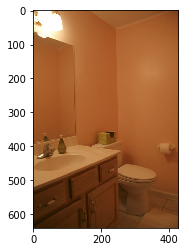


Captions:
a picture of a bathroom from the doorway 
an orange bathroom with a sink toilet and mirror 
this bathroom is painted x_UNK_ and has wood cabinets 
a bath room with a toilet a sink and a mirror 
a sink and cabinet in front of a mirror and a toilet next to them 

BLEU Score 9.55749159540752e-78

Prediction:a bathroom with a toilet and a toilet 
-----------------------------
Sample ID 22848


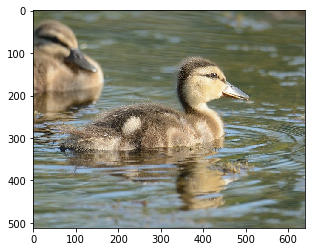


Captions:
a couple of x_UNK_ swimming across a lake 
two x_UNK_ in a pond staring at something 
a x_UNK_ is swimming in a big pond 
two young x_UNK_ surrounded by x_UNK_ in the water 
two x_UNK_ swimming beside each other in a pond 

BLEU Score 6.684949609530091e-155

Prediction:a x_UNK_ x_UNK_ x_UNK_ x_UNK_ x_UNK_ x_UNK_ 
-----------------------------
Sample ID 10589


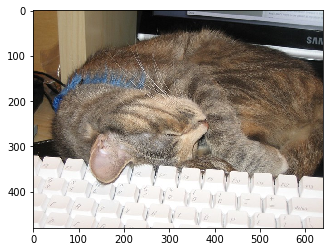


Captions:
a cat laying on top of a computer keyboard near a monitor 
cat x_UNK_ up sleeping by the keyboard and monitor 
a brown x_UNK_ with a blue x_UNK_ sleeping against a computer keyboard 
x_UNK_ colored cat laying down on a white keyboard 
a big cat x_UNK_ on a white x_UNK_ board 

BLEU Score 0.36889397323344053

Prediction:a cat laying on a keyboard on a bed 
-----------------------------
Sample ID 47037


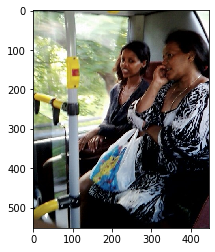


Captions:
two woman walking on the phone in the back of a bus 
two women are on the bus sitting next to each other 
two women are sitting on a bus and one of them is on the phone 
two women on a bus one talking on a cell phone 
a person sitting down talking on a cell phone 

BLEU Score 9.106239987484608e-155

Prediction:a person with a x_UNK_ phone in his mouth 
-----------------------------
Sample ID 70189


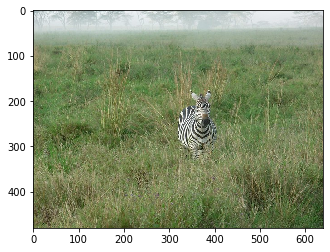


Captions:
a zebra is standing in a ground of long grass 
a small zebra walking around in a grassy field 
a black and white zebra in some tall grass and bushes 
a zebra is standing in the middle of the grass staring at the x_UNK_ 
a lone zebra is walking in tall green grass 

BLEU Score 0.43167001068522526

Prediction:a zebra standing in a grassy field with trees 
-----------------------------
Sample ID 81340


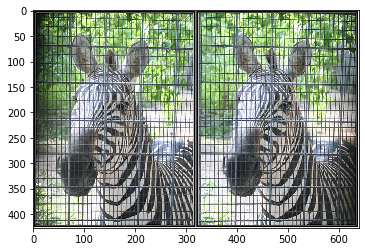


Captions:
two pictures of a x_UNK_ zebra placed side by side 
two striped zebras are looking through a fence 
zebra behind a x_UNK_ fence at a zoo 
two photos of a zebra in a zoo behind a metal x_UNK_ fence 
two x_UNK_ of a zebra looking from behind a fence 

BLEU Score 1.4256605770826504e-231

Prediction:a pole with a sign xFor x_UNK_ x_UNK_ 
-----------------------------
Sample ID 77636


c:\users\ayhok\appdata\local\programs\python\python37\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


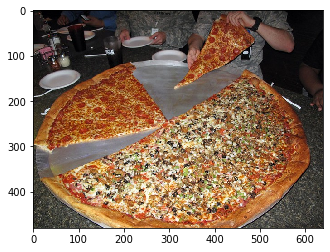


Captions:
a pizza with lots of x_UNK_ sitting on a counter 
a very huge pizza with different toppings on a giant pan 
a very large pizza with pepperoni and x_UNK_ and someone taking x_UNK_ slice 
there is a pizza with many toppings and one slice x_UNK_ 
the x_UNK_ pizza x_UNK_ have x_UNK_ seen with plates and cups 

BLEU Score 4.29307862935549e-78

Prediction:a pizza with a lot of pizza on it 
-----------------------------
Sample ID 73666


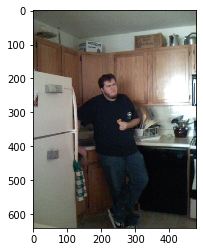


Captions:
a man standing in a kitchen with a piece of food in his hand 
a man eating something xWhile standing in the corner of a kitchen 
a man leaning on the counter of a kitchen eating 
this man is standing in a kitchen eating food 
a large man in a kitchen leaning against the sink 

BLEU Score 0.7598356856515925

Prediction:a man standing in a kitchen with a x_UNK_ x_UNK_ 
-----------------------------
Sample ID 46334


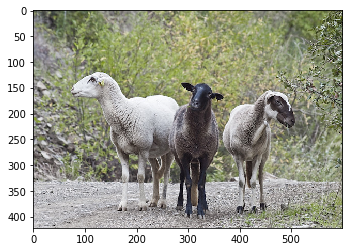


Captions:
a herd of x_UNK_ walking down a road way 
three x_UNK_ stand next to each other and look different x_UNK_ 
the animals standing in the x_UNK_ are x_UNK_ x_UNK_ of sheep 
three small sheep are standing on a road 
some animals are standing on a dirt path 

BLEU Score 9.106239987484608e-155

Prediction:a group of sheep grazing on a grassy plain 
-----------------------------
Sample ID 32382


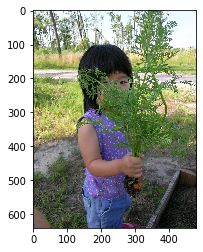


Captions:
a little girl standing in a field with a plant in her hands 
a little girl holding up a x_UNK_ pulled carrot 
a little girl holding a plant in front of her face 
small asian child holding up plant in front of x_UNK_ 
a young girl holding a plant in front of her face 

BLEU Score 5.929498746342409e-78

Prediction:a woman standing in front of a x_UNK_ x_UNK_ 
-----------------------------
Sample ID 10190


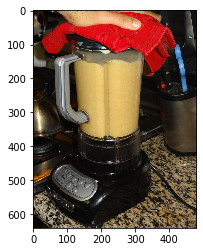


Captions:
hand holding down the top of a blender 
a blender is x_UNK_ a yellow x_UNK_ with someone holding the top 
a person x_UNK_ down on top of a x_UNK_ 
someone is holding the x_UNK_ on a blender 

BLEU Score 0.4111336169005197

Prediction:a x_UNK_ x_UNK_ blender is x_UNK_ a x_UNK_ 
-----------------------------
Sample ID 23588


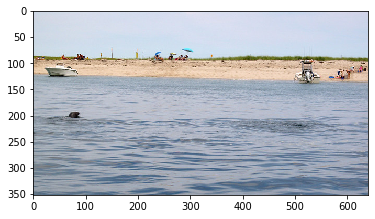


Captions:
there are two animals that are swimming in the water by the beach 
a couple of small x_UNK_ in the water 
people are enjoying a beautiful day on the beach 
two x_UNK_ boats are parked on the beach near x_UNK_ of people 
boats floating in the water near the shore 

BLEU Score 0.34846944887433073

Prediction:a person on a boat in the water near the water 
-----------------------------
Sample ID 32062


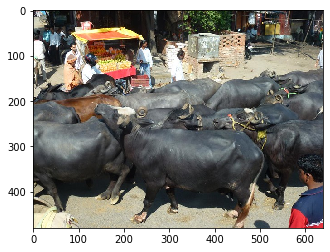


Captions:
a herd of x_UNK_ walking through a town x_UNK_ by men 
a herd of cattle is x_UNK_ through a street past people and x_UNK_ 
cows walking in a row down an x_UNK_ street 
a herd of cattle being x_UNK_ down a dirt road 
a bunch of cows are standing in a x_UNK_ 

BLEU Score 1.5728604687011317e-231

Prediction:a group of people are sitting on a bus 
-----------------------------
Sample ID 23331


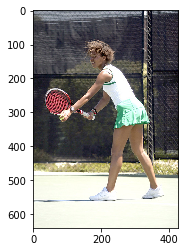


Captions:
a pretty young lady holding a tennis racquet on a tennis court 
a woman is holding a tennis racket on a court 
a woman holding a tennis racquet on a court 
a female tennis player setting xFor a serve 
a women that is on a court playing tennis 

BLEU Score 8.531468375170499e-78

Prediction:a woman is playing tennis on a court 


In [37]:
no_samples = 20
np.random.seed(22)
test_indices = np.random.permutation(len(img_name_val))[0:no_samples]

for ind in test_indices:
    print_pred(img_name_val[ind])

In [36]:
np.save('loss_attention_40.npy', lossList)

In [140]:
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

encoder.save(os.path.join(MODEL_DIR, 'encoder_attention'))
#decoder.save_weights(os.path.join(MODEL_DIR, 'decoder_attention_glove'), )

W0112 03:00:50.775379 28056 save_impl.py:84] Skipping full serialization of Keras layer <tensorflow.python.keras.saving.saved_model.load.Dense object at 0x00000224359F4550>, because it is not built.


In [214]:
encoderlol = Encoder(embedding_dim)
encoderlol.build(input_shape=(64,2048))
print(encoderlol.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             multiple                  409800    
Total params: 409,800
Trainable params: 409,800
Non-trainable params: 0
_________________________________________________________________
None


In [216]:
print(decoder.summary())

Model: "rnn__decoder_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      multiple                  200800    
_________________________________________________________________
gru_1 (GRU)                  multiple                  1403904   
_________________________________________________________________
dense_10 (Dense)             multiple                  262656    
_________________________________________________________________
dense_11 (Dense)             multiple                  515052    
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  366081    
Total params: 2,748,493
Trainable params: 2,748,493
Non-trainable params: 0
_________________________________________________________________
None
